In [5]:
import os, sys
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'StarNet'))
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits as pyfits
import umap
from sklearn.datasets import load_iris

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from starnet.utils.data_utils.augment import convolve_spectrum
from starnet.utils.data_utils.restructure_spectrum import rebin, continuum_normalize, ensure_constant_sampling

In [6]:
# Define parameters needed for continuum fitting
LINE_REGIONS = [[4210, 4240], [4250, 4410], [4333, 4388], [4845, 4886], [5160, 5200], [5874, 5916], [6530, 6590]]
SEGMENTS_STEP = 10.  # divide the spectrum into segments of 10 Angstroms

In [7]:
home = os.getenv('HOME')
scratch = os.getenv('SCRATCH')
starnet_data_folder = os.path.join(home, 'StarNet/starnet/data/')
intrigoss_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/intrigoss/train/') 
phoenix_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/train/') 
phoenix_wave_path = home+'/'+'/projects/rrg-kyi/group_writable/spectra/grids/phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/'
ambre_grid_path = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/grids/AMBRE/train/')
#obs_wave_filepath = os.path.join(home, 'projects/rrg-kyi/group_writable/spectra/UVES_4835-5395.npy')
#wave_grid_obs = np.load(obs_wave_filepath)

#print(wave_grid_obs)
#print(len(wave_grid_obs))
wave_grid_obs = np.linspace(4835,5395,num=10000)

In [8]:
def get_phoenix_spectrum(spectrum_path, wave_grid_path):
    
    """
    Given the path of a Phoenix spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the Phoenix spectrum file, e.g. '/path/to/lte04000-1.00-1.0.Alpha=+0.50.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist_spectrum = pyfits.open(spectrum_path)
    hdulist_wavegrid = pyfits.open(wave_grid_path)
    
    flux = hdulist_spectrum[0].data
    wav = hdulist_wavegrid[0].data
    
    # For Phoenix, need to convert from vacuum to air wavelengths.
    # The IAU standard for conversion from air to vacuum wavelengths is given
    # in Morton (1991, ApJS, 77, 119). For vacuum wavelengths (VAC) in
    # Angstroms, convert to air wavelength (AIR) via:
    #  AIR = VAC / (1.0 + 2.735182E-4 + 131.4182 / VAC^2 + 2.76249E8 / VAC^4)
    wav = wav / (
            1.0 + 2.735182E-4 + 131.4182 / wav ** 2 + 2.76249E8 / wav ** 4)
    
    return wav, flux

In [9]:
def get_phoenix_filename(teff, logg, feh, afe):
    """
    This function returns the name of the Phoenix spectrum file with the requested stellar parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: filename: Name of the .fits file containing an INTRIGOSS spectrum
    EXAMPLE: With input of teff=4000, logg=1.0, feh=-1.0, afe=0.5, it returns the string
             'lte04000-1.00-1.0.Alpha=+0.50.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    """
        
    str_teff = 'lte{:05d}'.format(teff)
    str_logg = '-{:03.2f}'.format(logg)
    str_feh = '{:02.1f}'.format(feh)
    if feh>0: 
        str_feh = '+' + str_feh
        
    if afe == 0:
        str_afe = ''
    elif afe < 0:
        str_afe = '.Alpha={:03.2f}'.format(afe)
    elif afe > 0:
        str_afe = '.Alpha=+{:03.2f}'.format(afe)

    filename = '{}{}{}{}.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'.format(str_teff, str_logg, str_feh, str_afe)

    return filename

In [10]:
def get_intrigoss_spectrum(path):
    
    """
    Given the path of an INTRIGOSS spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the INTRIGOSS spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.fits'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    
    hdulist = pyfits.open(path)
    flux_data = hdulist[1].data
    
    wav = flux_data['wavelength']
    flux = flux_data['surface_flux']
    
    return wav, flux

In [11]:
def get_ambre_spectrum(path):
    
    """
    Given the path of an AMBRE spectrum .fits file, this function retrieves the flux and wavelength data
    
    INPUT: path: The path to the AMBRE spectrum file, e.g. '/path/to/alpp050_am100_t4000g10_v1_f.AMBRE'
    
    RETURNS: wav: wavelength data
             flux: flux data
    """
    flux = np.genfromtxt(path,usecols=-1)
    wav = np.genfromtxt(path,usecols= 0)
    
    return wav, flux

In [41]:
def get_ambre_filename(teff, logg, feh, afe):
    
    """
    This function returns the name of the AMBRE spectrum file with the requested stellar parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: filename: Name of the .fits file containing an AMBRE spectrum
    EXAMPLE: With input of teff=4000, logg=1.0, feh=-1.0, afe=0.5, it returns the string
             'alpp050_am100_t4000g10_v1_f.AMBRE'
    """
    filename_fin = ''
    # Construct the full AMBRE .fits file name from stellar parameters
    for root, dirs, files in os.walk(ambre_grid_path):
        for filename in files:
            if teff == float(filename[1:5]):
                if filename[7] == '-':
                    if logg == -1*float(filename[8:11]):
                        if filename[22] == '-':
                            if feh == -1*float(filename[23:27]):
                                if filename[29] == '-':
                                    if afe == -1*float(filename[30:34]):
                                        filename_fin = filename
                                elif afe == float(filename[30:34]):
                                    filename_fin = filename
                                    
                        elif feh == float(filename[23:27]):
                            if filename[29] == '-':
                                if afe == -1*float(filename[30:34]):
                                    filename_fin = filename
                            elif afe == float(filename[30:34]):
                                filename_fin = filename
    
                        
                elif logg == float(filename[8:11]):
                    if filename[22] == '-':
                        if feh == -1*float(filename[23:27]):
                            if filename[29] == '-':
                                if afe == -1*float(filename[30:34]):
                                    filename_fin = filename
                            elif afe == float(filename[30:34]):
                                    filename_fin = filename
                                    
                    elif feh == float(filename[23:27]):
                        if afe == -1*float(filename[30:34]):
                            filename_fin = filename
                        elif afe == float(filename[30:34]):
                            filename_fin = filename
    
    
        
    return filename_fin

In [13]:
def find_closest_ambre_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the AMBRE
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the AMBRE grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             4000, 1.0, -1.0, 0.5
    """
    
        # AMBRE grid spacing
    if teff <= 3900:
        teff_grid = np.arange(2500, 4000, 200)
    elif teff >= 4000:
        teff_grid = np.arange(4000, 8500, 250)
    logg_grid = np.arange(-0.5, 6, 0.5)
    if feh >= -1.0:
        feh_grid = np.arange(-1.5, 1.5, 0.25)
    elif feh >= -3.0 and feh < -1.0:
        feh_grid = np.arange(-3.5,-1.0, 0.5)
    elif feh < -3.0:
        feh_grid = np.arange(-5.0,-3.0, 1.0)
    afe_grid = np.arange(-0.40, 1.00, 0.20) 
    
    
    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    match_afe = round(match_afe,2)
    match_logg = round(match_logg,2)
    match_feh = round(match_feh,2)
    
    return match_teff, match_logg, match_feh, match_afe

In [14]:
def find_closest_ambre_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the AMBRE
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the AMBRE grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             4000, 1.0, -1.0, 0.5
    """
    
        # AMBRE grid spacing
    if teff <= 3900:
        teff_grid = np.arange(2500, 4000, 200)
    elif teff >= 4000:
        teff_grid = np.arange(4000, 8500, 250)
    logg_grid = np.arange(-0.5, 6, 0.5)
    if feh >= -1.0:
        feh_grid = np.arange(-1.5, 1.5, 0.25)
    elif feh >= -3.0 and feh < -1.0:
        feh_grid = np.arange(-3.5,-1.0, 0.5)
    elif feh < -3.0:
        feh_grid = np.arange(-5.0,-3.0, 1.0)
    afe_grid = np.arange(-0.40, 1.00, 0.20) 
    
    
    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    match_afe = round(match_afe,2)
    match_logg = round(match_logg,2)
    match_feh = round(match_feh,2)
    
    return match_teff, match_logg, match_feh, match_afe

In [15]:
def find_closest_phoenix_match(teff, logg, feh, afe):
    
    """
    Given a set of stellar parameters, this function will return the stellar parameters from the Phoenix
    grid which are closest to the supplied parameters.
    
    INPUT: teff: Effective temperature (K)
           logg: Surface gravity
           feh: Metallicity (dex)
           afe: Alpha elements abundance [alpha/Fe]

    RETURNS: Closest matching stellar parameters from the Phoenix grid
    EXAMPLE: With input of teff=3900, logg=1.1, feh=-1.1, afe=0.6, it returns 4 values:
             3900, 1.0, -1.0, 0.5
    """

    # Phoenix spectra grid spacing
    teff_grid = np.arange(2300,7000,100)
    teff_grid = np.concatenate((teff_grid, np.arange(7000,12001,200)))
    logg_grid = np.arange(0, 6.1, 0.5)
    feh_grid = np.arange(-4., -2.0, 1)
    feh_grid = np.concatenate((feh_grid, np.arange(-2.0, 1.01, 0.5)))
    afe_grid = np.arange(-0.2, 1.21, 0.2)

    # Find closest parameter values
    match_teff = teff_grid[np.argmin(np.abs(teff - teff_grid))]
    match_logg = logg_grid[np.argmin(np.abs(logg - logg_grid))]
    match_feh = feh_grid[np.argmin(np.abs(feh - feh_grid))]
    match_afe = afe_grid[np.argmin(np.abs(afe - afe_grid))]
    
    match_afe = round(match_afe,2)
    
    return match_teff, match_logg, match_feh, match_afe

In [16]:
def intrigoss_one_file(name):


    wav_intrigoss,flux_intrigoss = get_intrigoss_spectrum(intrigoss_grid_path+name)

    return wav_intrigoss,flux_intrigoss

In [17]:
def phoenix_one_file(name):


    wavegrid_path = os.path.join(phoenix_wave_path, 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
    wav_phoenix, flux_phoenix = get_phoenix_spectrum(phoenix_grid_path+name, wavegrid_path)


    return wav_phoenix,flux_phoenix

In [18]:
def ambre_one_file(name):

    wav_ambre, flux_ambre = get_ambre_spectrum(ambre_grid_path+name)
    

    return wav_ambre,flux_ambre

In [19]:
def pre_processor_phoenix(wav_phoenix,flux_phoenix):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    #wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    #wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    #wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    wav_phoenix = wav_phoenix[wave_indices_phoenix]
    #wav_ambre = wav_ambre[wave_indices_ambre]
    #flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    flux_phoenix = flux_phoenix[wave_indices_phoenix]
    #flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    #err_intrigoss = np.zeros(len(flux_intrigoss))
    err_phoenix = np.zeros(len(flux_phoenix))
    #err_ambre = np.zeros(len(flux_ambre))
    #_, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    _, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    #_, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)


    
# Rebin to UVES wave grid
    #flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    #flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    #flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_phoenix

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [20]:
def pre_processor_intrigoss(wav_intrigoss,flux_intrigoss):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    #wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    #wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    #wav_phoenix = wav_phoenix[wave_indices_phoenix]
    #wav_ambre = wav_ambre[wave_indices_ambre]
    flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    #flux_phoenix = flux_phoenix[wave_indices_phoenix]
    #flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    err_intrigoss = np.zeros(len(flux_intrigoss))
    #err_phoenix = np.zeros(len(flux_phoenix))
    #err_ambre = np.zeros(len(flux_ambre))
    _, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    #_, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    #_, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

# Rebin to UVES wave grid
    flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    #flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    #flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_intrigoss

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [21]:
def pre_processor_ambre(wav_ambre,flux_ambre):


# Trim the wavelength and flux arrays according to observed wave grid
    extension = 10  # Angstroms
    wave_min_request = wave_grid_obs[0] - extension
    wave_max_request = wave_grid_obs[-1] + extension
    #wave_indices_intrigoss = (wav_intrigoss > wave_min_request) & (wav_intrigoss < wave_max_request)
    #wave_indices_phoenix = (wav_phoenix > wave_min_request) & (wav_phoenix < wave_max_request)
    wave_indices_ambre = (wav_ambre > wave_min_request) & (wav_ambre < wave_max_request)
    #wav_intrigoss = wav_intrigoss[wave_indices_intrigoss]
    #wav_phoenix = wav_phoenix[wave_indices_phoenix]
    wav_ambre = wav_ambre[wave_indices_ambre]
    #flux_intrigoss = flux_intrigoss[wave_indices_intrigoss]
    #flux_phoenix = flux_phoenix[wave_indices_phoenix]
    flux_ambre = flux_ambre[wave_indices_ambre]

# Degrade resolution
    #err_intrigoss = np.zeros(len(flux_intrigoss))
    #err_phoenix = np.zeros(len(flux_phoenix))
    err_ambre = np.zeros(len(flux_ambre))
    #_, flux_intrigoss, _ = convolve_spectrum(wav_intrigoss, flux_intrigoss, err_intrigoss, to_resolution=47000)
    #_, flux_phoenix, _ = convolve_spectrum(wav_phoenix, flux_phoenix, err_phoenix, to_resolution=47000)
    _, flux_ambre, _ = convolve_spectrum(wav_ambre, flux_ambre, err_ambre, to_resolution=47000)

# Rebin to UVES wave grid
    #flux_intrigoss = rebin(wave_grid_obs, wav_intrigoss, flux_intrigoss)
    #flux_phoenix = rebin(wave_grid_obs, wav_phoenix, flux_phoenix)
    flux_ambre = rebin(wave_grid_obs, wav_ambre, flux_ambre)

# Continuum normalize the spectra
    #flux_intrigoss, _ = continuum_normalize(flux_intrigoss, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    #flux_phoenix, _ = continuum_normalize(flux_phoenix, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)
    flux_ambre, _ = continuum_normalize(flux_ambre, LINE_REGIONS, wave_grid_obs, SEGMENTS_STEP)

    #print('DONE')
    
    return flux_ambre

# Mask telluric lines
#flux_intrigoss = mask_tellurics('telluric_lines.txt', flux_intrigoss, wave_grid_obs
#flux_phoenix = mask_tellurics('telluric_lines.txt', flux_phoenix, wave_grid_obs)
#flux_ambre = mask_tellurics('telluric_lines.txt', flux_ambre, wave_grid_obs)

In [23]:
def getIntriParams(file_path):
    with pyfits.open(file_path) as hdulist:
          #flux = hdulist[1].data['surface_flux']
        param_data = hdulist[0].header
        teff = param_data['TEFF']
        logg = param_data['LOG_G']
        m_h = param_data['FEH']
        a_m = param_data['ALPHA']
        
        return teff,logg,m_h,a_m
          #vt = param_data['VT']
          #params = [teff, logg, m_h, a_m, vt]

In [49]:
f_i = []
f_p = []
f_a = []
i_count = 0
for root, dirs, files in os.walk(intrigoss_grid_path):
    for name in files:
        teff_i,logg_i,feh_i,afe_i = getIntriParams(intrigoss_grid_path + name)
        
        wav_intrigoss,flux_intrigoss = intrigoss_one_file(name)
        #print(teff_i,logg_i,feh_i,afe_i)
        
        matched_teff_p,matched_logg_p,matched_feh_p,matched_afe_p = find_closest_phoenix_match(teff_i, logg_i, feh_i, afe_i)
        matched_teff_a,matched_logg_a,matched_feh_a,matched_afe_a = find_closest_ambre_match(teff_i, logg_i, feh_i, afe_i)
        
        file_p = get_phoenix_filename(matched_teff_p, matched_logg_p, matched_feh_p, matched_afe_p)
        #print(file_p)
        file_a = get_ambre_filename(matched_teff_a, matched_logg_a, matched_feh_a, matched_afe_a)
        #print(file_a)
        
        for root, dirs, files in os.walk(phoenix_grid_path):
            for name in files:
                if name == file_p:
                    #spec_filepath_phoenix = os.path.join(root, name)
                    wav_phoenix,flux_phoenix = phoenix_one_file(file_p)
                    pro_flux_phoenix = pre_processor_phoenix(wav_phoenix,flux_phoenix)
                    f_p.append(pro_flux_phoenix)
                    break
        
        for root, dirs, files in os.walk(ambre_grid_path):
            for name in files:
                if name == file_a:
                    #spec_filepath_ambre = os.path.join(root, name)
                    wav_ambre,flux_ambre = ambre_one_file(file_a)
                    pro_flux_ambre = pre_processor_ambre(wav_ambre,flux_ambre)
                    f_a.append(pro_flux_ambre)
                    break
 
        

        
        
        pro_flux_intrigoss = pre_processor_intrigoss(wav_intrigoss,flux_intrigoss)
        
        
        f_i.append(pro_flux_intrigoss)
        
        
        
        i_count = i_count + 1 
        
        if i_count >= 20:
            break
        

/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/nrpu88/jupyter_py3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


In [50]:
  
        
f_i = np.asarray(f_i)
f_p = np.asarray(f_p)
f_a = np.asarray(f_a)

print(f_i)
print(f_a)
print(f_p)

#print(f_i.shape)

[[0.98619896 0.98283826 0.99105358 ... 0.9543547  0.97994321 0.97897107]
 [1.10935588 1.11488217 1.0934597  ... 0.89461775 0.94429793 0.97135323]
 [1.00974086 1.00991318 1.00986532 ... 0.99479045 0.99669768 0.99666984]
 ...
 [1.00455802 1.00442737 1.00461469 ... 0.99702203 0.99777842 0.99765187]
 [1.00603066 1.00624733 1.00692411 ... 0.99552499 0.99673937 0.99636434]
 [1.00137803 1.00123306 1.00105793 ... 0.99811618 0.99823757 0.99823007]]
[[0.99715289 0.99205089 0.99037427 ... 0.96954518 0.98147055 0.97568074]
 [1.01046358 1.01025987 1.010035   ... 0.99670434 0.99823134 0.9985207 ]
 [1.00157007 1.00144576 1.00149426 ... 0.99856513 0.99961476 0.9997019 ]
 ...
 [1.00520125 1.00507628 1.00497083 ... 0.99846782 0.99875953 0.99881115]
 [1.00491444 1.00470581 1.00473253 ... 0.99783327 0.99850457 0.99865689]
 [1.00712716 1.00677913 1.00679273 ... 0.99642528 0.99837027 0.99869358]]
[[1.05286463 1.05810563 1.1277384  ... 0.80154498 0.89575901 0.93284412]
 [1.00505645 1.00483793 1.00392885 ... 

In [51]:
grid_data = []
for i in f_i:
    grid_data.append(i)
for j in f_p:
    grid_data.append(j)
for k in f_a:
    grid_data.append(k)

grid_data = np.asarray(grid_data)
#print(grid_data.shape)

print(grid_data)

[[0.98619896 0.98283826 0.99105358 ... 0.9543547  0.97994321 0.97897107]
 [1.10935588 1.11488217 1.0934597  ... 0.89461775 0.94429793 0.97135323]
 [1.00974086 1.00991318 1.00986532 ... 0.99479045 0.99669768 0.99666984]
 ...
 [1.00520125 1.00507628 1.00497083 ... 0.99846782 0.99875953 0.99881115]
 [1.00491444 1.00470581 1.00473253 ... 0.99783327 0.99850457 0.99865689]
 [1.00712716 1.00677913 1.00679273 ... 0.99642528 0.99837027 0.99869358]]


In [52]:
reducer = umap.UMAP(init = 'random')
embedding = reducer.fit_transform(grid_data)

In [53]:
grid_target=[]
for i in range(len(f_i)):
    grid_target.append(0)
for j in range(len(f_p)):
    grid_target.append(1)
for k in range(len(f_a)):
    grid_target.append(2)

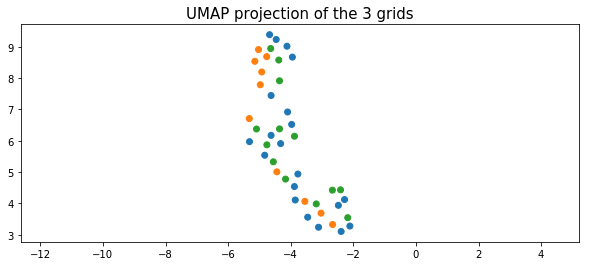

In [54]:
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in grid_target])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the 3 grids', fontsize=15);

#Blue-intrigoss
#Green-ambre
#Orange-phoenix

In [ ]:
with h5py.File(save_path, 'w') as f:  
    f.create_dataset('intrigoss_spectrum', data=np.asarray(intrigoss_spectrum))
    f.create_dataset('phoenix_spectrum', data=np.asarray(matched_phoenix_spectrum))
    f.create_dataset('ambre_spectrum', data=np.asarray(matched_ambre_spectrum))
    f.create_dataset('intrigoss_params', data=np.asarray(intrigoss_params))
    f.create_dataset('phoenix_params', data=np.asarray(matched_phoenix_params))
    f.create_dataset('ambre_params', data=np.asarray(matched_ambre_params))